# Imports

## Packages

In [1]:
import os
import pandas as pd
import numpy as np
import random
import importlib
from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.svm import SVC
from sklearn.metrics import precision_recall_curve, auc
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from pylab import *
import seaborn as sns
import tensorflow as tf
from scipy import stats
from mlxtend.evaluate import paired_ttest_5x2cv

pd.set_option("display.max_rows", None, "display.max_columns", None)
plt.rcParams['figure.facecolor']='white'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

## Helpers

In [2]:
import sys
sys.path.append("../")

# glove preprocessings
import Helpers.Glove_transform
importlib.reload(Helpers.Glove_transform)
from Helpers.Glove_transform import GloveTransform

# Stanford tokenizer
import Helpers.Stanford_Tokenizer
importlib.reload(Helpers.Stanford_Tokenizer)
from Helpers.Stanford_Tokenizer import StanfordTokenizer

# Tweet tokenizer(from C-BiGRU paper)
import Helpers.Tweet_Tokenizer
importlib.reload(Helpers.Tweet_Tokenizer)
from Helpers.Tweet_Tokenizer import TweetTokenize

# glove embeddings
import Helpers.Glove_twitter_embeddings
importlib.reload(Helpers.Glove_twitter_embeddings)
from Helpers.Glove_twitter_embeddings import GloveTwitterEmbeddings

# glove common crawl
import Helpers.Glove_CommonCrawl_embeddings
importlib.reload(Helpers.Glove_CommonCrawl_embeddings)
from Helpers.Glove_CommonCrawl_embeddings import GloveCommomCrawlEmbeddings

# Word embedding(from C-BiGRU paper)
import Helpers.Word2Vec_Twitter
importlib.reload(Helpers.Word2Vec_Twitter)
from Helpers.Word2Vec_Twitter import Word2VecTwitter

# Fasttext embedding
import Helpers.Fasttext_Twitter
importlib.reload(Helpers.Fasttext_Twitter)
from Helpers.Fasttext_Twitter import FasttextTwitter

# Padding
import Helpers.Padding
importlib.reload(Helpers.Padding)
from Helpers.Padding import Padding

# Kears sklearn CNN classifier
import Helpers.CNN_SciKeras_Classifier
importlib.reload(Helpers.CNN_SciKeras_Classifier)
from Helpers.CNN_SciKeras_Classifier import CNN_classifier

# Kears sklearn CBiGRU classifier
import Helpers.CBiGRU_SciKeras_Classifier
importlib.reload(Helpers.CBiGRU_SciKeras_Classifier)
from Helpers.CBiGRU_SciKeras_Classifier import CBiGRU_classifier

/root/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Directory to store results

In [10]:
results_dir = Path('../../results/mmovet15+')
results_dir.mkdir(parents=True, exist_ok=True)

results_plot = Path('../../results/plots')
results_plot.mkdir(parents=True, exist_ok=True)

# Dataset

In [25]:
# read train dataset
MMoveT15_2 = "../../Datasets/MMoveT15+/"
train = pd.read_json(MMoveT15_2 + 'mmovet15_2_train.json')
x_train = train["text_translated"]
y_train = train[["cardinality", "migrant_movement", "any_mention_of_migrants"]]

# Multi label encode
y_train = y_train.loc[:, 'cardinality':'any_mention_of_migrants'].replace(True, pd.Series(y_train.columns, y_train.columns)).replace(False, np.nan)
y_train = y_train.T.apply(lambda x: x.dropna().tolist()).tolist()

mlp = MultiLabelBinarizer()
y_train = mlp.fit_transform(y_train)
print("Total number of datapoints in train set:",len(train))

Total number of datapoints in train set: 2987


# Experiments

## SVM + TF-IDF

### Pipeline

In [43]:
# Make it an Multilabel classifier
multilabel_classifier = MultiOutputClassifier(SVC(probability=True), n_jobs=-1)

# Define component objects of our pipeline then create it!
objs = [("tfidf", TfidfVectorizer(ngram_range=(1,2))),
        ("svm", multilabel_classifier)]
pipe = Pipeline(objs)
pipe.named_steps

{'tfidf': TfidfVectorizer(ngram_range=(1, 2)),
 'svm': MultiOutputClassifier(estimator=SVC(probability=True), n_jobs=-1)}

### Cross validation

In [44]:
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe.set_params(svm__estimator__C=1)
pipe.set_params(tfidf__ngram_range=(1, 2))
cv_results = cross_validate(pipe, 
                                x_train, y_train,
                                cv=cv, 
                                n_jobs = -1,
                                scoring="average_precision")

In [45]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results["test_score"]), np.std(cv_results["test_score"])))

Average Precision: Mean-0.404, std-0.029


In [46]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"), index=False)

## CNN + Glove Twitter Word Embeddings

### Pipeline

In [5]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f836aecc700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f836aef15b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [11]:
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
pipe_CNN.set_params(net__model__output_size=3)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring="average_precision")

In [12]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

Average Precision: Mean-0.364, std-0.018


In [13]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"), index=False)

### Plot training loss curve

In [14]:
x_transform = pipe_CNN[:-1].fit_transform(x_train)
x_transform.shape

(2987, 42, 200)

In [15]:
model = CNN_classifier(output_size=3, verbose=0)
model.fit(x_transform, y_train)

CNN_classifier(
	model=<function CNN_model at 0x7ff8dbc36b80>
	build_fn=None
	warm_start=False
	random_state=42
	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7ff8dbc5f940>
	loss=binary_crossentropy
	metrics=['accuracy']
	batch_size=50
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.1
	shuffle=True
	run_eagerly=False
	epochs=40
	output_size=3
	class_weight=None
	model__seq_len=42
	model__emb_dim=200
)

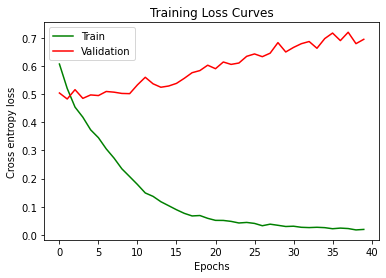

In [16]:
ap = round(max(model.history_['val_accuracy']), 3)

# get training and validation loss
epochs = [i for i in range(len(model.history_["loss"]))]
train_loss = model.history_['loss']
train_acc = model.history_['accuracy']
valid_loss = model.history_['val_loss']
valid_acc = model.history_['val_accuracy']

plt.plot(epochs,train_loss,'g-');
plt.plot(epochs,valid_loss,'r-');
# plt.plot(epochs,valid_acc,'b-');
# plt.plot(epochs,train_acc,'y-');
plt.title('Training Loss Curves');
plt.xlabel('Epochs');
plt.ylabel('Cross entropy loss');
plt.legend(['Train','Validation', "Val Accuracy", "Train Accuracy"]);
# plt.savefig("plots/CBiGRU_MMove15_batch(%d)_%s_wd(%.3f)_exlrs(%.3f)_batch_norm(%r).png" %(net_bz, net_opt, net_wd, net_lr, net_bn))
# plt.savefig("plots/Kim_MMove15_batch(%d)_%s_lr(%.3f)_batch_norm(%r).png" %(net_bz, net_opt, net_lr, net_bn))
plt.show()

### Hypothesis Test for Comparing SVM+TF-IDF and CNN+Glove

In [21]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))

ttest = stats.ttest_ind(SVM_results["Average Precision"], CNN_results["Average Precision"])

print("P Value:", ttest.pvalue)
# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

P Value: 1.0
Algorithms probably have the same performance


## CNN + Glove Common Crawl Word Embeddings

### Pipeline

In [36]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7f24d12a9700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7f24d12cd5b0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [40]:
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
pipe_CNN.set_params(net__model__output_size=3)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring="average_precision")

In [41]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

Average Precision: Mean-0.373, std-0.017


In [17]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CNN.csv"), index=False)

## CNN + Word2Vec Twitter Embeddings

### Pipeline

In [18]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7fba74ba1c10>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7fba74bcb7c0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [19]:
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
pipe_CNN.set_params(net__model__output_size=3)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=-1,
                            scoring="average_precision")

In [20]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

Average Precision: Mean-0.370, std-0.017


In [21]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CNN.csv"), index=False)

## CNN + FastText Twitter Embeddings

### Pipeline

In [22]:
objs_CNN = [
     ("Preprocess", GloveTransform()),
        ("Tokenize", StanfordTokenizer()),
        ("Fasttext", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding()),
        ("net", CNN_classifier())
              ] 
pipe_CNN = Pipeline(objs_CNN)

pipe_CNN.named_steps

{'Preprocess': GloveTransform(),
 'Tokenize': StanfordTokenizer(),
 'Fasttext': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(),
 'net': CNN_classifier(
 	model=<function CNN_model at 0x7fba74ba1c10>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=<keras.optimizer_v2.adadelta.Adadelta object at 0x7fba74bcb7c0>
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=50
 	validation_batch_size=None
 	verbose=1
 	callbacks=None
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=40
 	class_weight=None
 )}

### Cross validation

In [23]:
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
pipe_CNN.set_params(net__verbose=0)
pipe_CNN.set_params(net__model__output_size=3)
cv_results_CNN = cross_validate(pipe_CNN, 
                            x_train, 
                            y_train,
                            cv=cv,
                            n_jobs=2,
                            scoring="average_precision")

In [24]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CNN["test_score"]), np.std(cv_results_CNN["test_score"])))

Average Precision: Mean-0.375, std-0.018


In [25]:
results = pd.DataFrame(cv_results)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CNN.csv"), index=False)

## C-BiGRU + Glove Twitter Word Embeddings

### Pipeline

In [45]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveTwitterEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveTwitterEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fba74b53700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fba74bcbaf0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [46]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__model__output_size=3)
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring="average_precision")

In [47]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

Average Precision: Mean-0.377, std-0.013


In [48]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"), index=False)

### Hypothesis Test for Comparing CNN+Glove and C-BiGRU+Glove

In [22]:
CNN_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CNN.csv"))
CBiGRU_results = pd.read_csv(Path.joinpath(results_dir, "Glove_Twitter_Embeddings_CBiGRU.csv"))

ttest = stats.ttest_ind(CBiGRU_results["Average Precision"], CNN_results["Average Precision"])

# interpret the result
if ttest.pvalue <= 0.05:
    print('Difference between mean performance is probably real')
else:
    print('Algorithms probably have the same performance')

Difference between mean performance is probably real


## C-BiGRU + Glove Common Crawl Word Embeddings

### Pipeline

In [30]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", GloveCommomCrawlEmbeddings(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': GloveCommomCrawlEmbeddings(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fba74b53700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fba74bcbaf0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [31]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__model__output_size=3)
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring="average_precision")

In [32]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

Average Precision: Mean-0.383, std-0.021


In [33]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Glove_Common_Crawl_Embeddings_CBiGRU.csv"), index=False)

## C-BiGRU + Word2Vec Twitter Embeddings

### Pipeline

In [34]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", Word2VecTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': Word2VecTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fba74b53700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fba74bcbaf0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [35]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__model__output_size=3)
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   n_jobs = -1,
                                   scoring="average_precision")

In [36]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

Average Precision: Mean-0.384, std-0.020


In [37]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "Word2Vec_Twitter_CBiGRU.csv"), index=False)

## C-BiGRU + FastText Twitter Embeddings

### Pipeline

In [38]:
objs_CBiGRU = [("Tokenize", TweetTokenize()),
        ("W2V", FasttextTwitter(transformTo="concat")),
        ("Pad", Padding(seq_length=150)),
        ("net", CBiGRU_classifier())
              ] 
pipe_CBiGRU = Pipeline(objs_CBiGRU)

pipe_CBiGRU.named_steps

{'Tokenize': TweetTokenize(),
 'W2V': FasttextTwitter(transformTo='concat'),
 'Pad': Padding(seq_length=150),
 'net': CBiGRU_classifier(
 	model=<function CBiGRU_model at 0x7fba74b53700>
 	build_fn=None
 	warm_start=False
 	random_state=42
 	optimizer=adam
 	loss=binary_crossentropy
 	metrics=['accuracy']
 	batch_size=32
 	validation_batch_size=None
 	verbose=1
 	callbacks=[<keras.callbacks.EarlyStopping object at 0x7fba74bcbaf0>]
 	validation_split=0.1
 	shuffle=True
 	run_eagerly=False
 	epochs=5
 	class_weight=None
 )}

### Cross validation

In [39]:
pipe_CBiGRU.set_params(net__verbose=0)
pipe_CBiGRU.set_params(net__model__output_size=3)
cv = MultilabelStratifiedKFold(n_splits=10, shuffle=True, random_state=42)
cv_results_CBiGRU = cross_validate(pipe_CBiGRU,
                                   x_train,
                                   y_train,
                                   cv=cv,
                                   scoring="average_precision")

In [40]:
print("Average Precision: Mean-%.3f, std-%.3f"%(np.mean(cv_results_CBiGRU["test_score"]), np.std(cv_results_CBiGRU["test_score"])))

Average Precision: Mean-0.382, std-0.020


In [41]:
results = pd.DataFrame(cv_results_CBiGRU)["test_score"]
results.rename("Average Precision", inplace=True)
results.to_csv(Path.joinpath(results_dir, "FastText_Twitter_CBiGRU.csv"), index=False)

# Hypothesis Test

In [5]:
SVM_results = pd.read_csv(Path.joinpath(results_dir, "SVM_TFIDF.csv"))

for i, file in enumerate(os.listdir(results_dir)):
    if "SVM" not in file:
        other_results = pd.read_csv(Path.joinpath(results_dir, file))
        print(file.replace(".csv",""))

        ttest = stats.ttest_ind(SVM_results["Average Precision"], other_results["Average Precision"])
        print("P Value:", ttest.pvalue)

        # interpret the result
        if round(ttest.pvalue, 2) <= 0.1:
            print('Difference between mean performance is probably real')
        else:
            print('Algorithms probably have the same performance')
        print("------------------------------------------------------")

Glove_Common_Crawl_Embeddings_CNN
P Value: 0.675870016013101
Algorithms probably have the same performance
------------------------------------------------------
Word2Vec_Twitter_CNN
P Value: 0.675870016013101
Algorithms probably have the same performance
------------------------------------------------------
Glove_Twitter_Embeddings_CNN
P Value: 0.990108183664404
Algorithms probably have the same performance
------------------------------------------------------
Glove_Twitter_Embeddings_CBiGRU
P Value: 0.020235683790875352
Difference between mean performance is probably real
------------------------------------------------------
Word2Vec_Twitter_CBiGRU
P Value: 0.10265337741949179
Difference between mean performance is probably real
------------------------------------------------------
Glove_Common_Crawl_Embeddings_CBiGRU
P Value: 0.09232476571358268
Difference between mean performance is probably real
------------------------------------------------------
FastText_Twitter_CNN
P Valu

# Plots

In [6]:
data = pd.DataFrame(columns=["x_axis","Average Precision", "Experiments", "Model"])
for i, file in enumerate(os.listdir(results_dir)):
        data_sample = pd.read_csv(Path.joinpath(results_dir, file))
        if "CNN" in file:
            data_sample["Model"] = "CNN"
            file = file.replace("CNN", "")
        elif "CBiGRU" in file:
            data_sample["Model"] = "C-BiGRU"
            file = file.replace("CBiGRU", "")
        else: data_sample["Model"] = "SVM"
        data_sample["Experiments"] = file.replace("_", "\n").replace(".csv","")
        data_sample["x_axis"]=i
        data = pd.concat([data, data_sample[["x_axis","Average Precision", "Experiments", "Model"]]])
        
data = data.astype({"Experiments":"category", "Model":"category", "x_axis": "category", "Average Precision":"float64"})

In [7]:
grp = data.groupby(['Model', 'Experiments'])['Average Precision'].mean().sort_values().iloc[::-1]
grp_index = grp[~grp.isna()].index 
seen = set()
seen_add = seen.add
order = [x[1] for x in grp_index if not (x[1] in seen or seen_add(x[1]))][::-1]

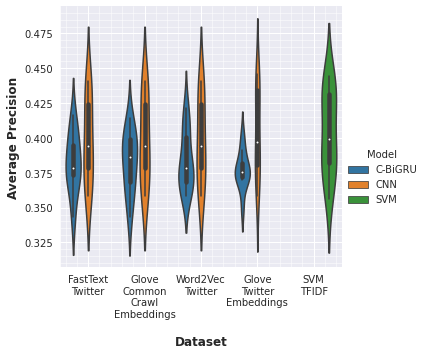

In [11]:
sns.set_style("darkgrid")
 
g = sns.catplot(x="Experiments", y="Average Precision",
               data=data, kind="violin", hue="Model", order=order)

for ax in g.axes.flat:
    ax.get_xaxis().set_minor_locator(AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(AutoMinorLocator())
    ax.grid(visible=True, which='major', color='w', linewidth=1.0)
    ax.grid(visible=True, which='minor', color='w', linewidth=0.5)
xlabel('Dataset', fontsize=12, fontweight='bold')
ylabel('Average Precision', fontsize=12, fontweight='bold')
plt.savefig(Path.joinpath(results_plot, "MMoveT15+.pdf"))
plt.show()